# DO NOT RUN THIS WITHOUT HAVING RAN SNAPS CORRECION FIRST


# Snaps analysis (2nd step)

## - Requirements:

### * This program runs on the output of the  "Correction" program (1 step) 
### * you must edit your experiment parameters in the "Modifiable User Parameters" box.
### * You also must edit the number of mothers and the threshold segmentation values in order to improve your results. Check it out in the following boxes.


## - Output:

### * Mother cell parameters  (length, area, fluorescence, etc.) ("data.csv")
### * Same as the above but for every cell in the picture (not just the mother cells)

## Libraries

In [1]:
%matplotlib inline
import cv2 #Image segmentation Library
import numpy as np #Numerical functions lib
from matplotlib import pyplot as plt #Basic ploting lib
import sys
import os #Lib for get the operative system sintaxis
from glob import glob #library used for get the file paths
import seaborn as sns #Library used for a nicer plotting
#from sklearn import linear_model#Machine learning package for a smart plot fit
#from sklearn import datasets
import pandas as pd
import random

#CUSTOM FUNCTIONS


# Quicksort algorithm implementation
def quicksort(l):
        if l:
                left = [x for x in l if x < l[0]]
                right = [x for x in l if x > l[0]]
                if len(left) > 1:
                        left = quicksort(left)
                if len(right) > 1:
                        right = quicksort(right)
                return left + [l[0]] * l.count(l[0]) + right

# Switches rows and columns in a list of lists
def coltorow(alist): 
    arr = [list(i) for i in zip(*alist)]
    return arr

# Custom peak detection algorithm y = data, thresh = peak heigth, peakdist= mininimum distance between peaks
def indexes(y,thresh,peakdist): 
    dy = np.diff(y)
    ind = []
    for i in range(len(dy)):
        if len(ind) > 0:
            if dy[i] < dy[int(i-1)] and dy[i] <- thresh and i - peakdist > ind[-1]:
                ind.append(i)
        elif len(ind) == 0:
            if dy[i] < dy[int(i-1)] and dy[i] <- thresh:
                ind.append(i)
    return ind

# Custom contour sorting algorithm
def sort_contours(cnts, method="LtR"):
    reverse = False
    i = 0
    if method == "RtL" or method == "BtT":
        reverse = True
    if method == "TtB" or method == "BtB":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
    return (cnts, boundingBoxes)

## User modifiable  parameters:
##### please make sure you ran the cell after making any changes as merely changing them does not actually update any values

In [6]:
# pixel calibration 
camerapsize = 6.45
binning = 2
cMount = 0.7
objMag = 100
lensMag = 1

# Time parameters
# initialframe: (positive int) number of the image from which the user decides to start measuring.
# timebetweenframes: (positive int) time separation from one measurement to the next.
initialframe = 0 
timebetweenframes = 7

## Bellow this point, you only must edit the mother number and the segmentation threshold

## Program parameters 

In [7]:

initialtime=initialframe*timebetweenframes
pixelsize = camerapsize*binning/(cMount*objMag*lensMag)



red_dir = './correctedrfptif/' 
green_dir = './correctedgfptif/'
mask_dir = './jpegformask'  


#deltax = 20 
#deltay = 50 


f = open('parameters.csv', "w")
f.close()
f = open('parameters.csv', "w")

f.write('initialframe,timebetweenframes,camerapsize,binning,cMount,objMag,lensMag,deltay,deltax \n')
f.write(str(initialframe)+ ',' + str(timebetweenframes) + ',' + str(camerapsize) + ',' + str(binning) +\
        ',' + str(cMount) + ',' + str(objMag) + ',' + str(lensMag) + ',' + str(deltay) + ',' + str(deltax) + '\n')
f.close()

# Main code

In [8]:
files_mask = [] 
pattern_mask   = "*.jpg"

files_red = [] 
pattern_red   = "*.tif"

files_green = [] 
pattern_green   = "*.tif"

for dir,_,_ in os.walk(mask_dir):
    files_mask.extend(glob(os.path.join(dir,pattern_mask)))

for dir,_,_ in os.walk(red_dir):
    files_red.extend(glob(os.path.join(dir,pattern_red)))
    
for dir,_,_ in os.walk(green_dir):
    files_green.extend(glob(os.path.join(dir,pattern_green)))
    
position_names =  [x[1] for x in os.walk(red_dir)][0]

files_mask.sort()
files_mask = np.array(files_mask).reshape(len(position_names),(int(len(files_mask)/len(position_names)))).tolist()

files_red.sort()
files_red = np.array(files_red).reshape(len(position_names),(int(len(files_red)/len(position_names)))).tolist()

files_green.sort()
files_green = np.array(files_green).reshape(len(position_names),(int(len(files_green)/len(position_names)))).tolist()

if len(files_green[0]) == 0:
    GFPimages = False
else: 
    GFPimages = True

print (str(len(position_names)) + ' positions were found')
print(str(len(files_mask[0])) + ' images for segmentation found per position')
print(str(len(files_red[0])) + ' RFP images found per position')
print(str(len(files_green[0])) + ' GFP images found per position')

3 positions were found
4 images for segmentation found per position
4 RFP images found per position
0 GFP images found per position


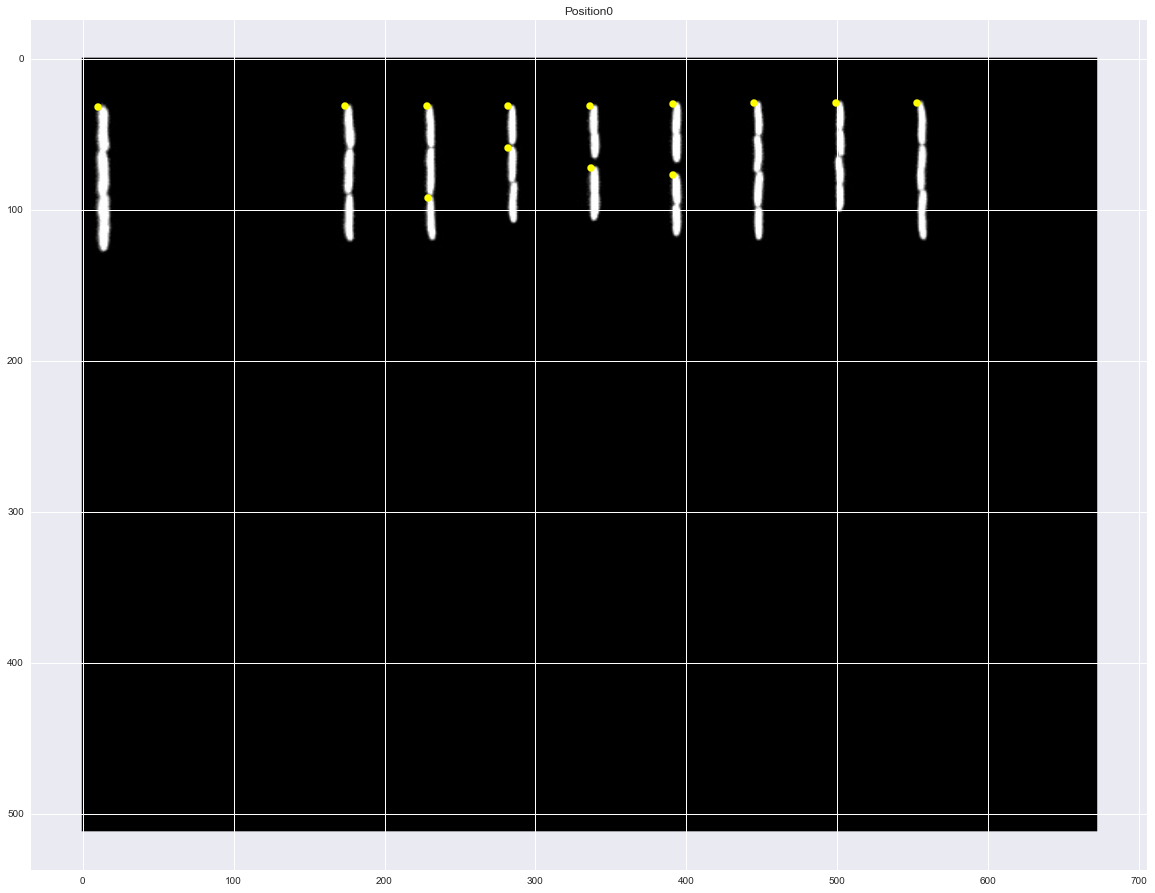

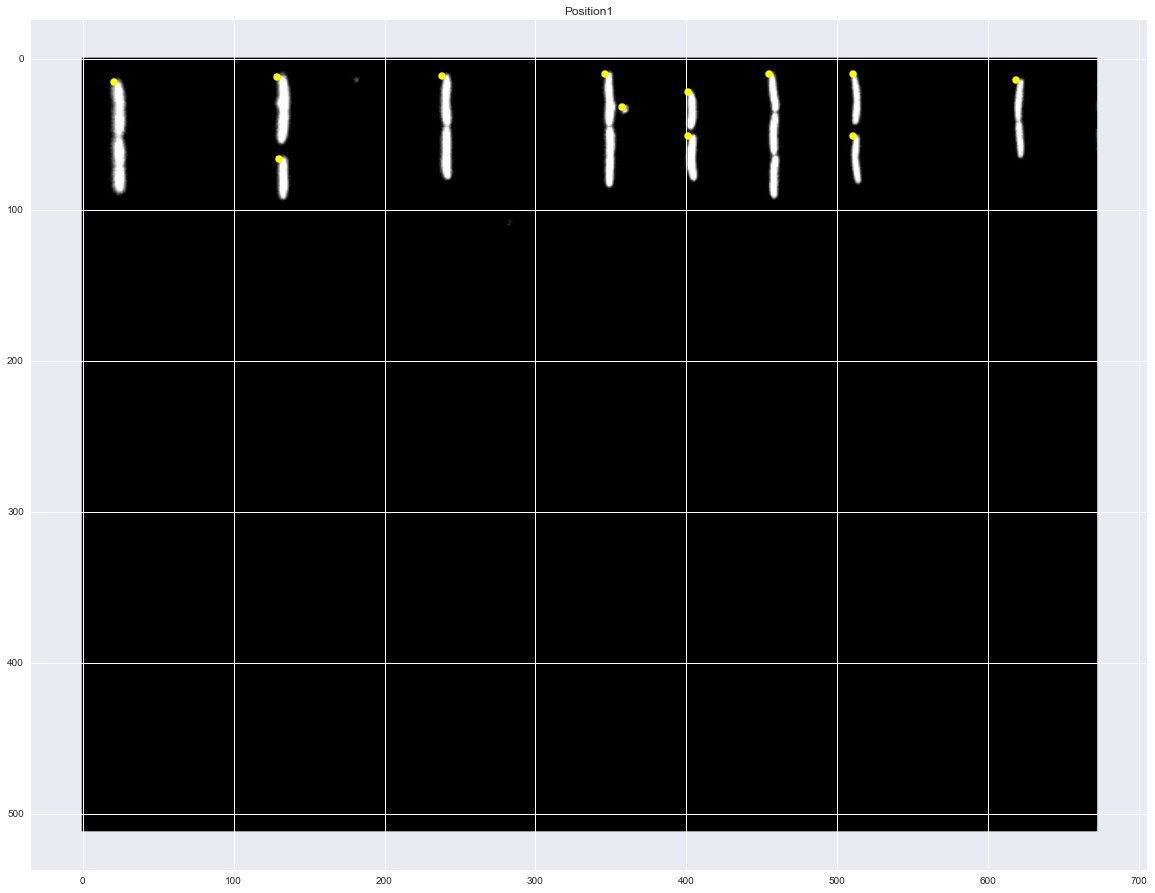

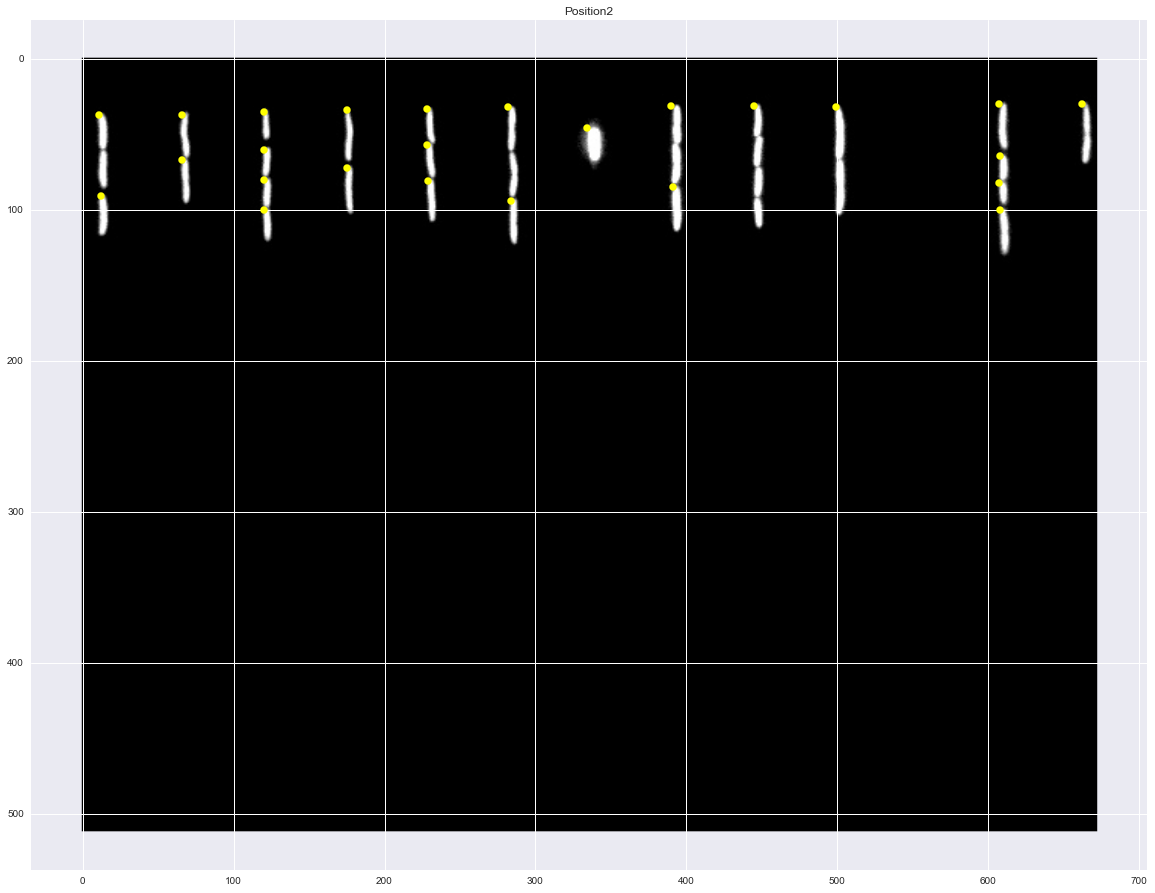

In [10]:
allcontours = []
allcoordinatesx = [] 
allcoordinatesy = []

for j in range(len(position_names)):
    coordinatesx = [] 
    coordinatesy = []
    
    first_image = files_mask[j][np.random.randint(0, len(files_mask[0]))] 
    img = cv2.imread(first_image,1)
    Yref = len(img)
    kernel_sharpen_3 = np.array([[-1,-1,-1,-1,-1],
                                 [-1,2,2,2,-1],
                                 [-1,2,8,2,-1],
                                 [-1,2,2,2,-1],
                                 [-1,-1,-1,-1,-1]]) / 8.0
    
    equ = cv2.filter2D(img, -1, kernel_sharpen_3) 
    gray = cv2.cvtColor(equ,cv2.COLOR_BGR2GRAY)
    threshold = 190
    ret, thresh = cv2.threshold(gray,threshold,255,cv2.THRESH_BINARY)
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) #contours

    allcontours.append(contours)
    for cnt in range(len(allcontours[j])):  
        x,y,w,h = cv2.boundingRect(allcontours[j][cnt])
        coordinatesx.append(x)
        coordinatesy.append(y)
    allcoordinatesx.append(coordinatesx)
    allcoordinatesy.append(coordinatesy)
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    ax.set_title("Position"+ str(j)) 
    ax.imshow(img)
    ax.scatter(allcoordinatesx[j],allcoordinatesy[j], s=50,color='yellow') 

# Please count the viable cells 
### Things to take into account:


##### - User must only count yellow dots
##### - User must keep in mind that the mother will always be on top of all other cells
##### - User must input one mother count, separated by commas, per position folder*


(ie. for 4 positions: 10,12,15,7 )


In [12]:
mothers = 9,9,12
threshold = 190,190,190

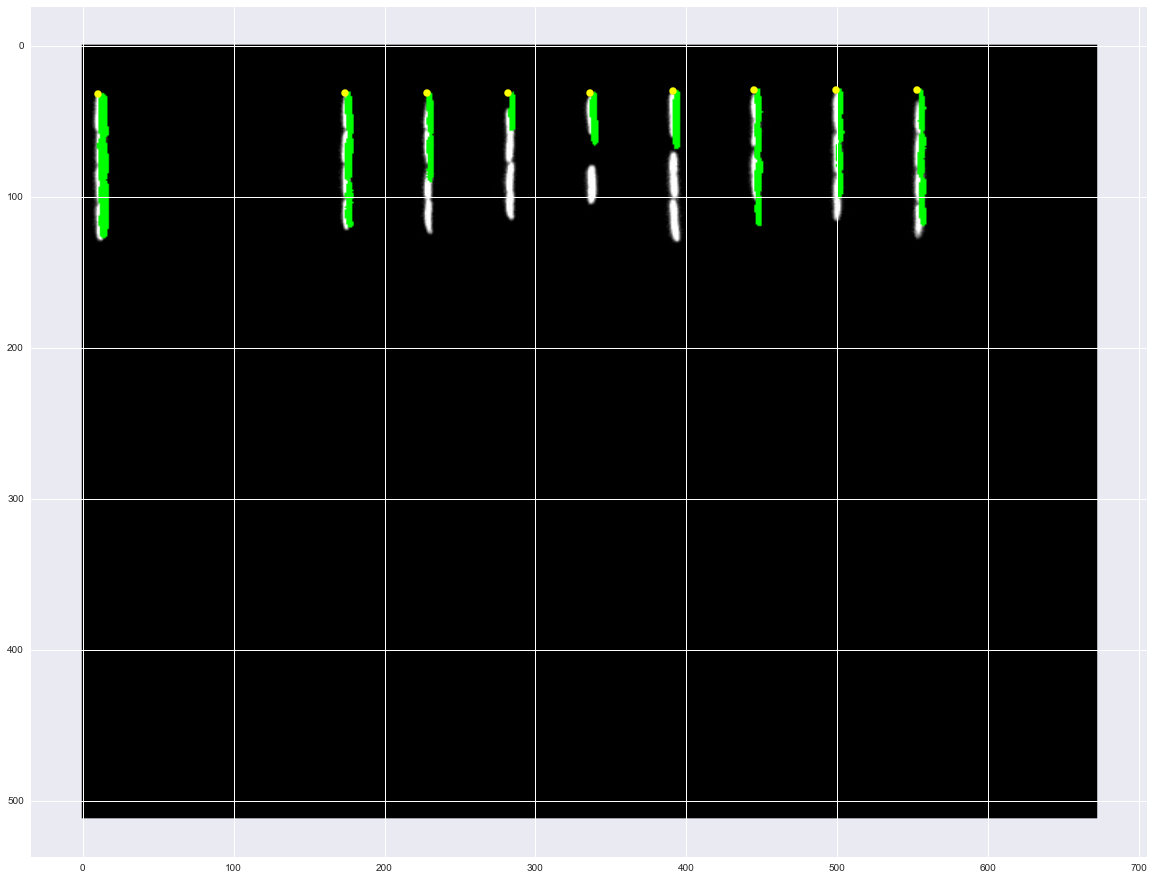

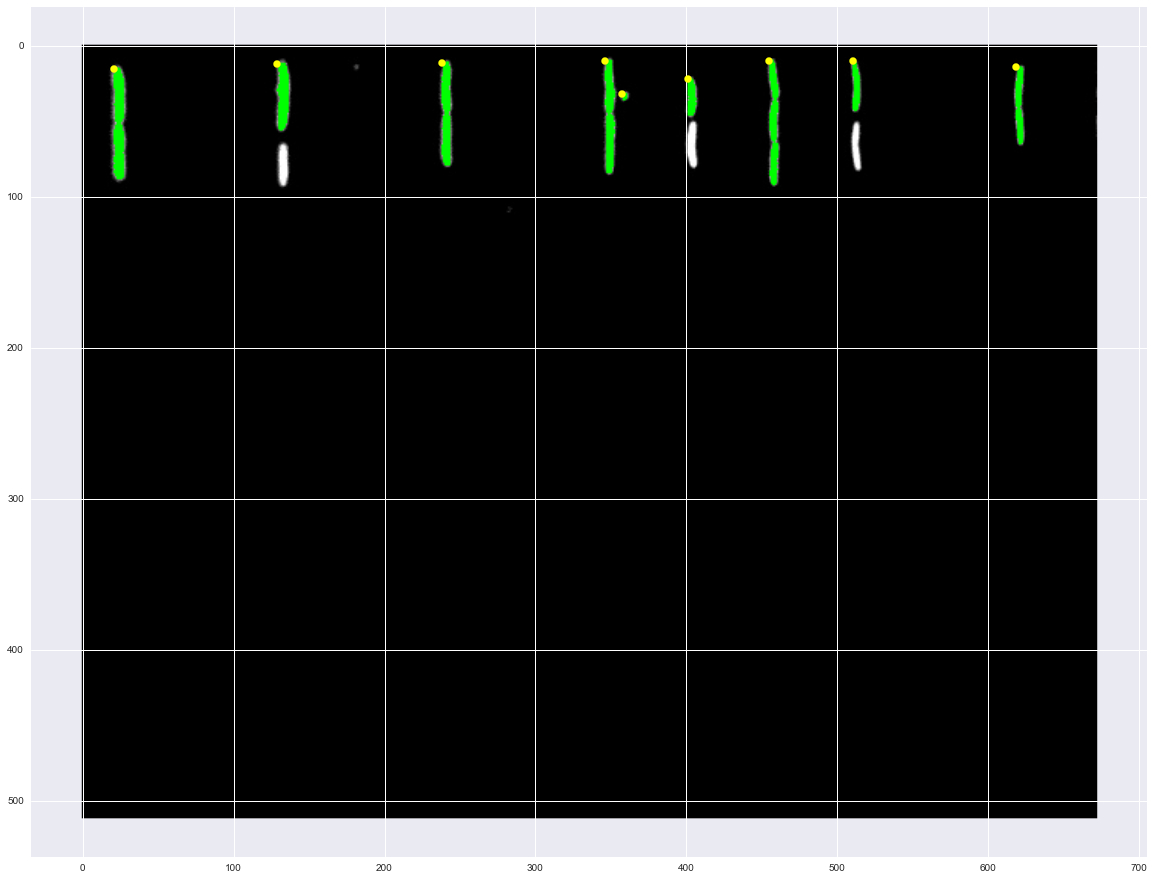

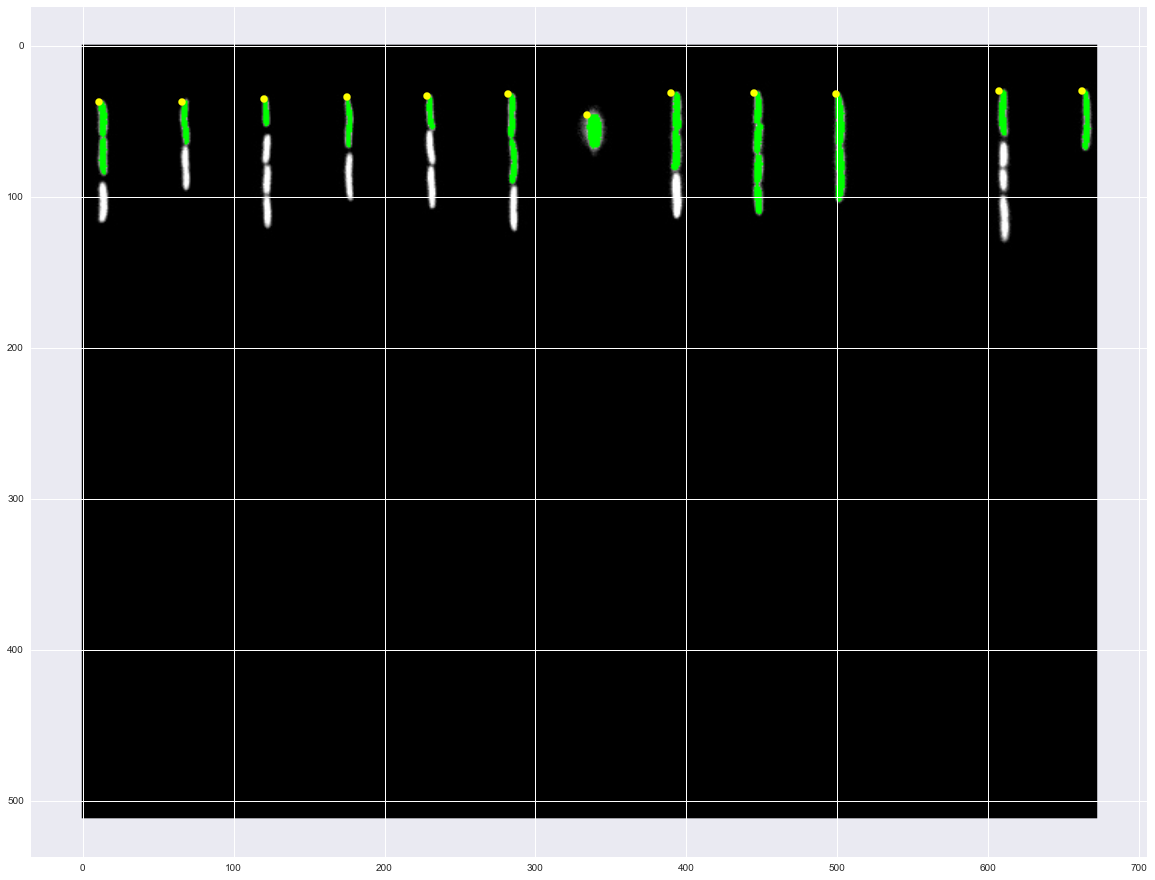

In [13]:
mx = []
my = []
posm = []
CPX = []
CPY = []


for j in range(len(position_names)):    
    
    first_image = files_mask[j][np.random.randint(0, len(files_mask[0]))] 
    img = cv2.imread(first_image,1)
    temp = []
    temp2 = []
    mxtmp = []
    mytmp = []
    posmtmp = []
    CPXtmp = []
    CPYtmp = []

    for i in range(len(allcoordinatesy[j])):
        temp.append([allcoordinatesy[j][i],allcoordinatesx[j][i],int(i)])
    temp = quicksort(temp)
    
    for i in range(mothers[j]):
        temp2.append([temp[i][1],temp[i][0],temp[i][2]])
    temp2 = quicksort(temp2)
    
    for i in range(mothers[j]):
        mxtmp.append(temp2[i][0])
        mytmp.append(temp2[i][1])
        posmtmp.append(temp2[i][2])
        
    mx.append(mxtmp)
    my.append(mytmp)
    posm.append(posmtmp)
    
    """   
    for i in range(len(mx[j])):
        CPXtmp.append(range(mx[j][i]-deltax,mx[j][i]+deltax))
        CPYtmp.append(range(my[j][i]-deltay,my[j][i]+deltay))
    CPX.append(CPXtmp)
    CPY.append(CPYtmp)
    px = []
    py = []
    for cnt in range(len(allcontours[j])):
        x,y,w,h = cv2.boundingRect(allcontours[j][cnt]) 
        for k in range(len(CPX)):
            if x in CPX[k] and y in CPY[k] and y<my[k]: 
                py.append(y)
                px.append(x)
    """
    
    for i in range(len(mx[j])):
        coord = posm[j][i]
        cnt = allcontours[j][coord]
        cv2.drawContours(img, [cnt], 0, (0,255,0),-1) 
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    ax.imshow(img)
    ax.scatter(mx[j],my[j], s=50,color='yellow')

In [14]:
FULLlen = []
FULLwid = []
FULLasp = []
FULLare = []
FULLintR = []
FULLtime = []
if(GFPimages):
    FULLintG = []
allcontours = []
for k in range(len(position_names)):
    fulllen = []
    fullwid = []
    fullasp = []
    fullare = []
    fullintR = []
    fulltime = []
    if(GFPimages):
        fullintG = []
        allmeanG = []
        allintG = []
        allcvG = []
    imcontours = []
    for i in range(0,len(files_red[k])): #i = frame

        filepath_red = files_red[k][i]
        filepath_mask = files_mask[k][i]
    
        img = cv2.imread(filepath_mask, 1)
        img3 = cv2.imread(filepath_red, 2 | 4)
        intR = []
        if(GFPimages):
            filepath_green = files_green[k][i]
            img2 = cv2.imread(filepath_green, 2 | 4)
            intG = [] 
        equ = cv2.filter2D(img, -1, kernel_sharpen_3)
        gray = cv2.cvtColor(equ,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(gray,threshold[k],255,0)
        im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    
        length = []
        wid = []
        asp = []
        are = []
        intR = []
        time = []
        
        for cnt in range(len(contours)):
            listintR = []
            if(GFPimages):
                listintG = []
            aimg = np.zeros_like(img)
            cv2.drawContours(aimg, contours, cnt, (0,0,255), thickness= -1)
            pts = np.where(aimg != 0)
            listintR.append(img3[pts[0], pts[1]])                
            r = 0
            r = np.mean(listintR[0])
            intR.append(r)
            
            if(GFPimages):
                pts = np.where(aimg != 0)
                listintG.append(img2[pts[0], pts[1]])                
                G = 0
                G = np.mean(listintG[0])
                intG.append(G)            
       
            x,y,w,h = cv2.boundingRect(contours[cnt]) 
            area = cv2.contourArea(contours[cnt])
            length.append(h * pixelsize)
            wid.append(w * pixelsize)
            asp.append(w / h)
            are.append(area * pixelsize ** 2)
            intR.append(r)
            time.append(i * timebetweenframes)
        if(GFPimages):
            fullintG.append(intG)
        
        fulllen.append(length)
        fullwid.append(wid)
        fullasp.append(asp)
        fullare.append(are)
        fullintR.append(intR)
        fulltime.append(time)
        imcontours.append(contours)
        
    allcontours.append(imcontours)
    FULLlen.append(fulllen)
    FULLwid.append(fullwid)
    FULLasp.append(fullasp)
    FULLare.append(fullare)
    FULLintR.append(fullintR)
    FULLtime.append(fulltime)
    if(len(files_green[k])!=0):
        FULLintG.append(fullintG)

    print('Position ' + str(k)+ ' done')

Position 0 done
Position 1 done
Position 2 done


In [15]:
for k in range(len(allcontours)): #pos
    for j in range(len(allcontours[k])): #frame
        allcontours[k][j],bndrct = sort_contours(allcontours[k][j], method="TtB")
        allcontours[k][j] = allcontours[k][j][0:mothers[k]]
        allcontours[k][j],bndrct = sort_contours(allcontours[k][j], method="LtR")

In [ ]:
#poner cajitas/columnas

In [16]:
ALLlen = []
ALLwid = []
ALLasp = []
ALLare = []
ALLintR = []
ALLtime = []
if(GFPimages):
    ALLintG = []
for k in range(len(allcontours)): # pos
    alllen = []
    allwid = []
    allasp = []
    allare = []
    allintR = []
    alltime = []
    if(GFPimages):
        allintG = []
        allmeanG = []
        allintG = []
        allcvG = []
    
    for i in range(0,len(allcontours[k])): # frame

        intR = []

        filepath_red = files_red[k][i]
        filepath_mask = files_mask[k][i]
        
        img = cv2.imread(filepath_mask, 1)
        equ = cv2.filter2D(img, -1, kernel_sharpen_3)
        gray = cv2.cvtColor(equ,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(gray,threshold[k],255,0)

        img3 = cv2.imread(filepath_red, 2 | 4)
        if(GFPimages):
            filepath_green = files_green[k][i]
            img2 = cv2.imread(filepath_green, 2 | 4)
            intG = [] 
    
        length = []
        wid = []
        asp = []
        are = []
        intR = []
        time = []
        
        for cnt in range(len(allcontours[k][i])):
            listintR = []
            if(GFPimages):
                listintG = []
            aimg = np.zeros_like(img)
            cv2.drawContours(aimg, allcontours[k][i], cnt, (0,0,255), thickness= -1)
            pts = np.where(aimg != 0)
            listintR.append(img3[pts[0], pts[1]])                
            r = 0
            r = np.mean(listintR[0])
            intR.append(r)
            
            if(GFPimages):
                pts = np.where(aimg != 0)
                listintG.append(img2[pts[0], pts[1]])                
                G = 0
                G = np.mean(listintG[0])
                intG.append(G)            
       
            x,y,w,h = cv2.boundingRect(allcontours[k][i][cnt]) 
            area = cv2.contourArea(allcontours[k][i][cnt])
            length.append(h * pixelsize)
            wid.append(w * pixelsize)
            asp.append(w / h)
            are.append(area * pixelsize ** 2)
            intR.append(r)
            time.append(i * timebetweenframes)
            if(GFPimages):
                allintG.append(G)
        
        alllen.append(length)
        allwid.append(wid)
        allasp.append(asp)
        allare.append(are)
        allintR.append(intR)
        alltime.append(time)

    ALLlen.append(alllen)
    ALLwid.append(allwid)
    ALLasp.append(allasp)
    ALLare.append(allare)
    ALLintR.append(allintR)
    ALLtime.append(alltime)
    if(len(files_green[k])!=0):
        ALLintG.append(allintG)

    print('Position ' + str(k)+ ' done')

Position 0 done
Position 1 done
Position 2 done


# Data, Finally

### Mothers first

In [42]:
f = open('MotherData.csv', 'w')
f.close()
f = open('MotherData.csv', 'w')

if (GFPimages):
    f.write('Frame,Mother,Time(min),Length(um),Area(um**2),Width(um),L/W,MeanRFP,MeanGFP\n')
    for k in range(len(ALLlen)): #pos
        for j in range(len(ALLlen[k])): #frame
            for i in range(len(ALLlen[k][j])): #cell
                f.write(str(j + initialframe) + ',' + str(k)+ '_' +str(i) + ',' + str((j+initialframe)*timebetweenframes) \
                        + ',' + str(ALLlen[k][j][i]) + ',' + str(ALLare[k][j][i]) + ',' + str(ALLwid[k][j][i]) \
                        + ',' + str(ALLasp[k][j][i]) + ',' + str(ALLintR[k][j][i]) + ',' + str(ALLintG[k][j][i])+'\n')
else:
    f.write('Frame,Mother,Time(min),Length(um),Area(um**2),Width(um),L/W,MeanRFP \n')
    for k in range(len(ALLlen)): #pos
        for j in range(len(ALLlen[k])): #frame
            for i in range(len(ALLlen[k][j])): #cell
                f.write(str(j + initialframe) + ','+ str(k)+ '_' + str(i) + ',' + str((j+initialframe)*timebetweenframes) \
                        + ',' + str(ALLlen[k][j][i]) + ',' + str(ALLare[k][j][i]) + ',' + str(ALLwid[k][j][i]) \
                        + ',' + str(ALLasp[k][j][i]) + ',' + str(ALLintR[k][j][i]) + '\n')
f.close()

### Now all cells

In [50]:
f = open('AllCellData.csv', 'w')
f.close()
f = open('AllCellData.csv', 'w')

if (GFPimages):
    f.write('Position,Frame,Time(min),Length(um),Area(um**2),Width(um),L/W,MeanRFP,MeanGFP\n')
    for k in range(len(FULLlen)): #pos
        for j in range(len(FULLlen[k])): #frame
            for i in range(len(FULLlen[k][j])): #cell
                f.write(str(k) + ',' + str(j + initialframe) + ',' + str((j+initialframe)*timebetweenframes) \
                        + ',' + str(FULLlen[k][j][i]) + ',' + str(FULLare[k][j][i]) + ',' + str(FULLwid[k][j][i]) \
                        + ',' + str(FULLasp[k][j][i]) + ',' + str(FULLintR[k][j][i]) + ',' + str(FULLintG[k][j][i])+'\n')
else:
    f.write('Position,Frame,Time(min),Length(um),Area(um**2),Width(um),L/W,MeanRFP \n')
    for k in range(len(FULLlen)): #pos
        for j in range(len(FULLlen[k])): #frame
            for i in range(len(FULLlen[k][j])): #cell
                f.write(str(k) + ',' + str(j + initialframe) + ',' + str((j+initialframe)*timebetweenframes) \
                        + ',' + str(FULLlen[k][j][i]) + ',' + str(FULLare[k][j][i]) + ',' + str(FULLwid[k][j][i]) \
                        + ',' + str(FULLasp[k][j][i]) + ',' + str(FULLintR[k][j][i]) + '\n')
f.close()